**Domain**: Healthcare/Pharmaceutical Marketing 

The project, **A/B Testing for Drug Marketing Campaigns**, focuses on evaluating marketing campaigns targeting elderly patients (65+ years) in therapeutic areas like cardiovascular, neurology, and endocrinology. It leverages A/B testing to compare the effectiveness of a new campaign (e.g., video ads emphasizing ease of use) against an existing one (e.g., standard flyers), using metrics like prescription uptake. The healthcare domain is critical, as it patient-centric solutions for underserved populations, requiring data-driven commercial strategies to optimize campaign ROI and patient engagement.

In [2]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.power import NormalIndPower
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style("whitegrid")

In [3]:
# Load and Adapt Dataset
# Load Kaggle Marketing A/B Testing Dataset
df = pd.read_csv('marketing_AB.csv')

In [4]:
df.sample(5)

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
244839,244839,1101467,ad,False,23,Sunday,21
97065,97065,1022545,ad,False,9,Tuesday,15
75061,75061,1299291,ad,False,415,Wednesday,11
308742,308742,1141735,ad,False,30,Sunday,8
51205,51205,910901,psa,False,49,Tuesday,10


In [5]:
df.columns

Index(['Unnamed: 0', 'user id', 'test group', 'converted', 'total ads',
       'most ads day', 'most ads hour'],
      dtype='object')

In [6]:
# Drop unnecessary columns
df.drop(columns=['Unnamed: 0', 'user id'], inplace=True)

In [7]:
df.columns

Index(['test group', 'converted', 'total ads', 'most ads day',
       'most ads hour'],
      dtype='object')

In [8]:
# Convert 'converted' to integer
df['converted'] = df['converted'].astype(int)

In [9]:
df.converted.unique()

array([0, 1])

In [10]:
# Add synthetic healthcare columns for elderly patients
df['age'] = np.random.randint(65, 90, size=len(df))  # Age 65-90
df['health_condition'] = np.random.choice(['Cardiovascular', 'Neurology', 'Endocrinology'], size=len(df))

In [11]:
df.sample(5)

,test group,converted,total ads,most ads day,most ads hour,age,health_condition
402801,ad,0,21,Tuesday,12,70,Cardiovascular
129930,ad,0,72,Thursday,13,66,Cardiovascular
440252,ad,0,1,Saturday,22,80,Endocrinology
259451,ad,0,12,Monday,21,84,Endocrinology
308092,psa,0,17,Saturday,23,70,Endocrinology


In [12]:
# Filter for elderly patients
df = df[df['age'] >= 65]

In [13]:
df.age.unique()

array([65, 71, 70, 82, 67, 77, 81, 69, 73, 83, 87, 66, 89, 85, 84, 74, 78,
       72, 88, 79, 86, 80, 75, 68, 76])

In [14]:
# Save adapted dataset
df.to_csv('healthcare_marketing_AB.csv', index=False)

In [16]:
# Exploratory Data Analysis (EDA)
# Basic data overview
print("Dataset Info:")
print(df.info())
print("\nNull Values:")
print(df.isna().sum())
print("\nStatistical Summary:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   test group        588101 non-null  object
 1   converted         588101 non-null  int32 
 2   total ads         588101 non-null  int64 
 3   most ads day      588101 non-null  object
 4   most ads hour     588101 non-null  int64 
 5   age               588101 non-null  int32 
 6   health_condition  588101 non-null  object
dtypes: int32(2), int64(2), object(3)
memory usage: 26.9+ MB
None

Null Values:
test group          0
converted           0
total ads           0
most ads day        0
most ads hour       0
age                 0
health_condition    0
dtype: int64

Statistical Summary:
           converted      total ads  most ads hour            age
count  588101.000000  588101.000000  588101.000000  588101.000000
mean        0.025239      24.820876      14.469061  

In [17]:
# Frequency tables for categorical variables
for var in ['test group', 'most ads day', 'health_condition']:
    print(f"\nFrequency Table for {var}:")
    print(df[var].value_counts(normalize=True) * 100)


Frequency Table for test group:
test group
ad     96.000007
psa     3.999993
Name: proportion, dtype: float64

Frequency Table for most ads day:
most ads day
Friday       15.746955
Monday       14.805790
Sunday       14.519785
Thursday     14.110161
Saturday     13.885370
Wednesday    13.757501
Tuesday      13.174438
Name: proportion, dtype: float64

Frequency Table for health_condition:
health_condition
Cardiovascular    33.395454
Endocrinology     33.333560
Neurology         33.270986
Name: proportion, dtype: float64


In [18]:
# Preprocessing
# Detect outliers in 'total ads' using IQR
Q1 = df['total ads'].quantile(0.25)
Q3 = df['total ads'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['total ads'] < (Q1 - 1.5 * IQR)) | (df['total ads'] > (Q3 + 1.5 * IQR)))]

In [19]:
# Categorize hours into time slots
def categorize_hour(hour):
    if 5 <= hour < 12: return 'Morning'
    elif 12 <= hour < 17: return 'Afternoon'
    elif 17 <= hour < 21: return 'Evening'
    else: return 'Night'
df['time_slot'] = df['most ads hour'].apply(categorize_hour)

In [20]:
df.columns

Index(['test group', 'converted', 'total ads', 'most ads day', 'most ads hour',
       'age', 'health_condition', 'time_slot'],
      dtype='object')

In [21]:
df.sample(5)

,test group,converted,total ads,most ads day,most ads hour,age,health_condition,time_slot
215515,ad,0,39,Monday,18,84,Cardiovascular,Evening
248114,ad,0,30,Tuesday,13,80,Endocrinology,Afternoon
430704,ad,0,1,Friday,20,66,Cardiovascular,Evening
435892,ad,0,18,Saturday,14,70,Neurology,Afternoon
209333,ad,0,20,Thursday,14,83,Cardiovascular,Afternoon


In [26]:
df['total ads'].max()

61

### Terminology Explanations

- **Significance Level (α)**:
  - **Definition**: The probability of rejecting the null hypothesis when it is true (Type I error, or false positive). 
  - **Context in Project**: A significance level of 0.05 means there’s a 5% chance of incorrectly concluding that the new ad campaign (e.g., for liquid formulations) is more effective than the control (PSA) when it’s not. It’s a threshold to determine if the difference in prescription uptake rates is statistically significant.
  - **Why It Matters**: Ensures the A/B test results are reliable, minimizing false claims about campaign effectiveness, which is critical for Azurity’s data-driven commercial strategies.

- **Statistical Power (1 - β)**:
  - **Definition**: The probability of correctly rejecting the null hypothesis when it is false (i.e., detecting a true effect).
  - **Context in Project**: A power of 80% means there’s an 80% chance of detecting a real difference in prescription uptake between the `ad` (new campaign) and `psa` (control) groups if such a difference exists. It balances the risk of missing a true effect (Type II error).
  - **Why It Matters**: High power ensures the test is sensitive enough to identify meaningful campaign improvements, supporting company’s goal of optimizing ROI for elderly patient marketing.

- **p1, p2**:
  - **Definition**: The baseline conversion rates for the control (`p1`) and test (`p2`) groups. p1 = 0.017854` (1.7854% for PSA group) and `p2 = 0.025547` (2.5547% for ad group), derived from the Kaggle Marketing A/B Testing Dataset.
  - **Context in Project**: `p1` represents the proportion of elderly patients requesting a prescription after seeing the control campaign (PSA, e.g., a standard flyer). `p2` represents the same for the new campaign (ad, e.g., a video ad). These rates are used to calculate the effect size, determining how many samples are needed to detect this difference.
  - **Why It Matters**: Accurate `p1` and `p2` values ensure the sample size calculation reflects realistic expectations for campaign performance, aligning with Azurity’s need for actionable insights.

- **ad, psa**:
  - **Definition**: The two groups in the A/B test. `ad` refers to the test group exposed to the advertisement (new campaign), and `psa` refers to the control group exposed to a public service announcement (or equivalent, like a standard campaign).
  - **Context in Project**: In the healthcare context, `ad` represents elderly patients exposed to a new marketing campaign for company’s liquid formulations (e.g., a video highlighting ease of use). `psa` represents those exposed to an existing campaign (e.g., a standard flyer). The dataset labels users as `ad` or `psa` in the `test group` column, with `converted` indicating prescription uptake.
  - **Why It Matters**: Comparing `ad` vs. `psa` allows you to assess whether the new campaign increases prescription uptake, directly addressing Azurity’s goal of improving commercial outcomes for underserved populations.

### How These Terms Work Together in Chunk 5
- **Significance Level (α = 0.05)** and **Statistical Power (0.8)** are used in the `NormalIndPower().solve_power` function to calculate the sample size needed to detect a difference between `p1` (PSA conversion rate) and `p2` (ad conversion rate) with high confidence.
- The **effect size** (calculated as `(p2 - p1) / ((p * (1 - p)) ** 0.5)`) quantifies the difference between `ad` and `psa` groups’ conversion rates, informing the sample size (~5631 per group).
- **Random sampling** ensures each group (`ad` and `psa`) is equally represented in the subset `df_smpl`, reducing bias and enabling fair comparison in subsequent tests (e.g., t-test in Chunk 6).
- This setup ensures the A/B test is robust, aligning with Azurity’s need for reliable, data-driven insights to optimize marketing campaigns for elderly patients.

### Why These Terms Are Critical
- They ensure the A/B test is statistically valid, minimizing errors and maximizing the chance of detecting true campaign improvements.

In [27]:
# Sample Size Calculation
# Define parameters for sample size
p1, p2 = 0.017854, 0.025547  # PSA and ad conversion rates

p = (p1 + p2) / 2
effect_size = (p2 - p1) / ((p * (1 - p)) ** 0.5)

# Calculate sample size
power_analysis = NormalIndPower()
sample_size = power_analysis.solve_power(effect_size=effect_size, power=0.8, alpha=0.05, ratio=1)
print(f"Required sample size per group: {int(sample_size)}")

# Random sampling
df_smpl = df.groupby('test group', group_keys=False).apply(lambda x: x.sample(n=int(sample_size), random_state=42))

Required sample size per group: 5631


In [33]:
group_counts = df['test group'].value_counts()
print("Group sizes:", group_counts)

if group_counts['psa'] < sample_size:
    print("Warning: PSA group too small. Adjusting sample size.")
    sample_size = min(sample_size, group_counts['psa'])
df_smpl = df.groupby('test group', group_keys=False).apply(lambda x: x.sample(n=int(sample_size), random_state=42))

Group sizes: test group
ad     514716
psa     21328
Name: count, dtype: int64


In [28]:
# Statistical Testing
# T-test for test groups

control = df_smpl[df_smpl['test group'] == 'psa']['converted']
test = df_smpl[df_smpl['test group'] == 'ad']['converted']

t_stat, p_val = ttest_ind(test, control)
print(f"T-test: T-statistic: {t_stat:.2f}, P-value: {p_val:.4f}")
print("Reject H0: Significant difference in prescription uptake." if p_val < 0.05 else "Fail to reject H0.")

T-test: T-statistic: 2.60, P-value: 0.0092
Reject H0: Significant difference in prescription uptake.


In [49]:
# Odds ratio and confidence interval
contingency_table = pd.crosstab(df_smpl['test group'], df_smpl['converted'])
print("Contingency Table:")
print(contingency_table)
odds_ratio = (contingency_table.iloc[1,0] / contingency_table.iloc[1,1]) / (contingency_table.iloc[0,0] / contingency_table.iloc[0,1])  # ad vs. psa
log_odds_se = np.sqrt(contingency_table.apply(lambda x: 1/x).sum().sum())
ci_low, ci_high = np.exp(np.log(odds_ratio) - 1.96 * log_odds_se), np.exp(np.log(odds_ratio) + 1.96 * log_odds_se)
print(f"Odds Ratio: {odds_ratio:.2f}, 95% CI: [{ci_low:.2f}, {ci_high:.2f}]")
if odds_ratio < 1:
    print("Note: Odds ratio < 1 suggests lower conversion odds for ad vs. psa, despite t-test significance. Check raw conversion rates.")

Contingency Table:
converted      0   1
test group          
ad          5533  98
psa         5566  65
Odds Ratio: 1.52, 95% CI: [1.11, 2.08]


In [50]:
from scipy.stats import f_oneway
anova_result = f_oneway(
    df_smpl[df_smpl['health_condition'] == 'Cardiovascular']['converted'],
    df_smpl[df_smpl['health_condition'] == 'Neurology']['converted'],
    df_smpl[df_smpl['health_condition'] == 'Endocrinology']['converted']
)
print(f"ANOVA for Health Condition: F={anova_result.statistic:.2f}, p={anova_result.pvalue:.4f}")

ANOVA for Health Condition: F=1.27, p=0.2811


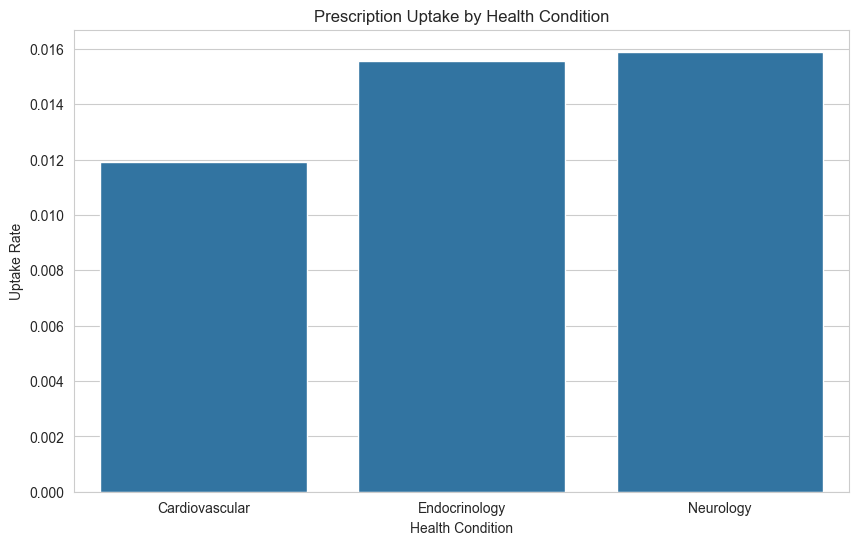

In [42]:
# : Visualizations
health_condition_rates = df_smpl.groupby('health_condition')['converted'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='health_condition', y='converted', data=health_condition_rates)
plt.title('Prescription Uptake by Health Condition')
plt.xlabel('Health Condition')
plt.ylabel('Uptake Rate')
plt.savefig('health_condition_uptake.png')
plt.show()

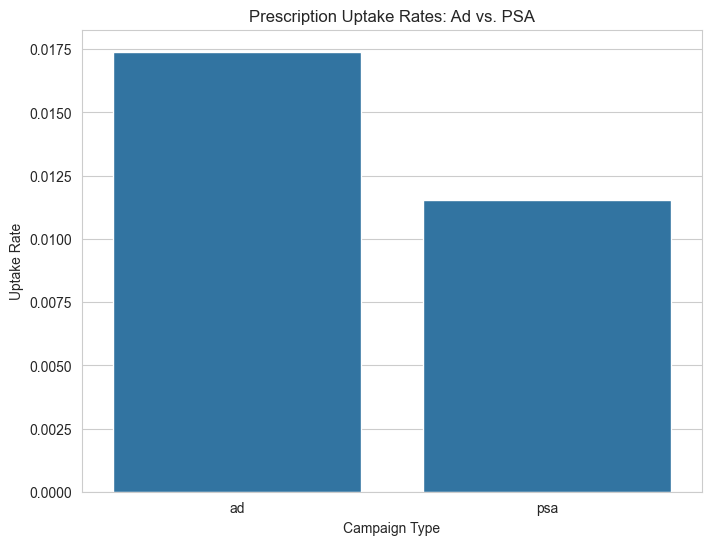

In [43]:
# Bar plot for test group uptake rates
conversion_rates = df_smpl.groupby('test group')['converted'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='test group', y='converted', data=conversion_rates)
plt.title('Prescription Uptake Rates: Ad vs. PSA')
plt.xlabel('Campaign Type')
plt.ylabel('Uptake Rate')
plt.savefig('test_group_uptake.png')
plt.show()

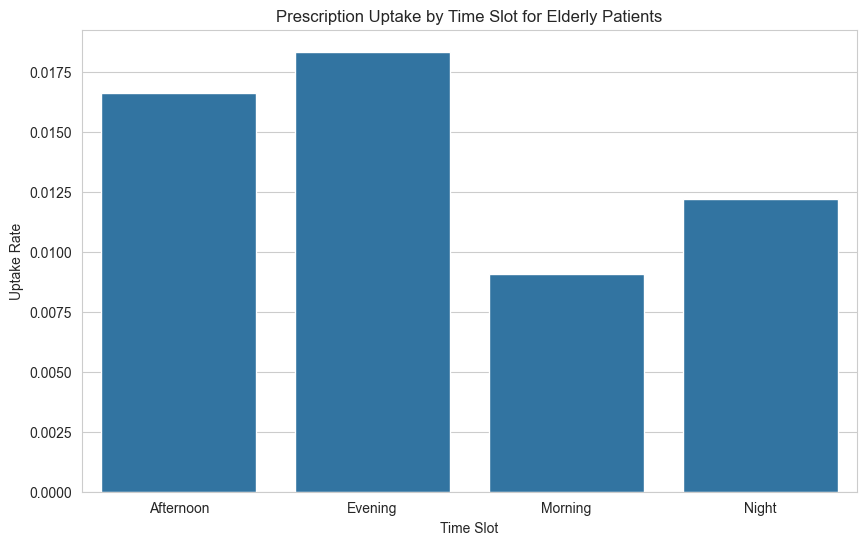

In [44]:
# Bar plot for time slot uptake rates
time_slot_rates = df_smpl.groupby('time_slot')['converted'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='time_slot', y='converted', data=time_slot_rates)
plt.title('Prescription Uptake by Time Slot for Elderly Patients')
plt.xlabel('Time Slot')
plt.ylabel('Uptake Rate')
plt.savefig('time_slot_uptake.png')
plt.show()